## MNIST Neural Network Example

In this notebook we will show how to make NumSA interact with TensorFlow. We will begin building a Neural Network that recognise digit from the MNIST dataset.

In [45]:
#We import all the library we are gona need
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numsa.TFHessian import *
from random import *
from tqdm.notebook import tqdm

mnist = tf.keras.datasets.mnist 
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("In the training set there are {} images, of size {}x{}."
      .format(train_images.shape[0],train_images.shape[1],train_images.shape[2]))
print("The data are labeled in the following categories, {}"
      .format(train_labels))
#We normalize the dataset
train_images = train_images/255.0
test_images = test_images/255.0
#We assemble the data set
# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)

In the training set there are 60000 images, of size 28x28.
The data are labeled in the following categories, [5 0 4 ... 5 6 8]


We can plot a random image from the MNIST data set using MatPlotLib.

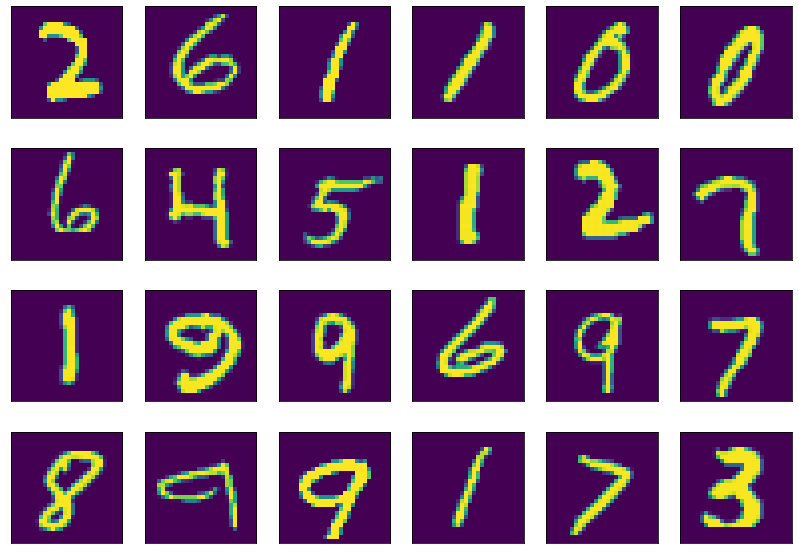

In [46]:
plt.figure(figsize=(14,10));
for i in range(24):
    plt.subplot(4,6,i+1)
    rn = randrange(0,train_images.shape[0]-1);
    plt.imshow(train_images[rn])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
plt.show()

Now we create the proper neural newtorks that we are intrested in studying, in particular to begin with we will sequantialey add two layer of size 128 and 10. But at the beging of the neural network we will put a layer that will "vectorify" the matrix storing the image.
We chose as activation function the RELU function to begin with.

In [47]:
#Keras Sequential allow us to place one layer after the other
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),#Vectorifying layer
    tf.keras.layers.Dense(128, activation='relu'),#128 weights layer
    tf.keras.layers.Dense(10)#10 leyers weights.
])
print("Number of trainable layers {}".format(len(model.trainable_weights)))
print("Number of weights trainable per layer 0, {}".format(model.trainable_weights[0].shape))
print("Number of weights trainable per layer 1, {}".format(model.trainable_weights[1].shape))
print("Number of weights trainable per layer 2, {}".format(model.trainable_weights[2].shape))
print("Number of weights trainable per layer 3, {}".format(model.trainable_weights[3].shape))

Number of trainable layers 4
Number of weights trainable per layer 0, (784, 128)
Number of weights trainable per layer 1, (128,)
Number of weights trainable per layer 2, (128, 10)
Number of weights trainable per layer 3, (10,)


We will now explicitly write the traing loop for the NN, in order to acceses it later when using NumSA.

In [48]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
#Importing a lost function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Prepare the metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

#Defining number of iterations
epochs = 21
for epoch in tqdm(range(epochs)):
    # Iterate over the batches of the dataset.
    for step, (batch_train_images, batch_train_labels) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as reg:
            with tf.GradientTape() as tape:
                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.
                logits = model(batch_train_images, training=True)  # Logits for this minibatch

                # Compute the loss value for this minibatch.
                loss_value = loss_fn(batch_train_labels, logits)

                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, model.trainable_weights)
                
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # Update training metric.
        train_acc_metric.update_state(batch_train_labels, logits)
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for batch_test_images, batch_test_labels in test_dataset:
        test_logits = model(batch_test_images, training=False)
        # Update val metrics
        test_acc_metric.update_state(batch_test_labels, test_logits)
    test_acc = test_acc_metric.result()
    test_acc_metric.reset_states()
print("Validation acc: %.4f" % (float(test_acc),))

  0%|          | 0/21 [00:00<?, ?it/s]

Validation acc: 0.9071


Now we test the neural network on a sample digit, randomly selected from the test dataset.

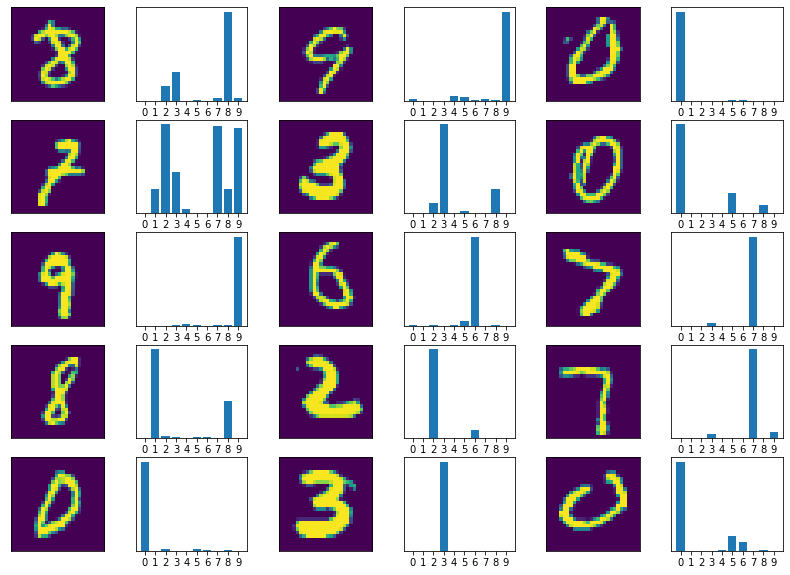

In [49]:
#Adding a softmax layer to get result in term of probability
pmodel = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
#Evaluating the test data set
predictions = pmodel(test_images);
plt.figure(figsize=(14,10));
for i in range(1,16):
    plt.subplot(5,6,(i*2)-1)
    rn = randrange(0,test_images.shape[0]-1);
    plt.imshow(test_images[rn])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(5,6,(i*2))
    plt.bar([0,1,2,3,4,5,6,7,8,9],predictions[rn])
    plt.xticks([0,1,2,3,4,5,6,7,8,9])
    plt.yticks([])
plt.show()

We now show how to use our package to compute the Hessian of the NN wrt to the weights with a fixed image, first we compute one partial Hessian for each layer of the Neural Network then we compute the the full Hessian of the neural network.

In [50]:
def Loss(weights):
    logits = model(batch_train_images, training=True) #Logits for this minibatch
    # Compute the loss value for this minibatch.
    loss_value = loss_fn(batch_train_labels, logits);
    return loss_value;
H = Hessian(Loss,model.trainable_weights)

In [51]:
partialH = np.zeros((128,128));
for i in tqdm(range(128)):
    v1 = tf.Variable(np.zeros((784,128),dtype=np.float32));
    v2 = np.zeros((128,),dtype=np.float32);
    v2[i]=1;
    v2 = tf.Variable(v2,dtype=np.float32)
    v3 = tf.Variable(np.zeros((128,10),dtype=np.float32));
    v4 = tf.Variable(np.zeros((10,),dtype=np.float32));
    v = [v1,v2,v3,v4]
    partialH[:,i] = H.action(v)[1].numpy().reshape(128,);

  0%|          | 0/128 [00:00<?, ?it/s]

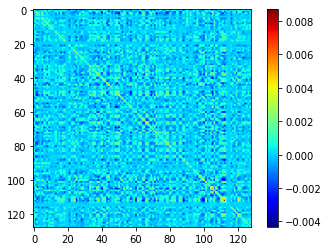

In [52]:
plt.imshow(partialH,cmap="jet")
plt.colorbar()

In [53]:
partialH = np.zeros((128*10,128*10));
for i in tqdm(range(128*10)):
    v1 = tf.Variable(np.zeros((784,128),dtype=np.float32));
    v2 = tf.Variable(np.zeros((128,),dtype=np.float32));
    v3 = np.zeros((128*10),dtype=np.float32);
    v3[i] = 1.0;
    v3 = tf.Variable(v3.reshape([128,10]));
    v4 = tf.Variable(np.zeros((10,),dtype=np.float32));
    v = [v1,v2,v3,v4]
    #print(H.action(v)[2].numpy().reshape((128*10,)))
    partialH[:,i] = H.action(v)[2].numpy().reshape(128*10,);

  0%|          | 0/1280 [00:00<?, ?it/s]

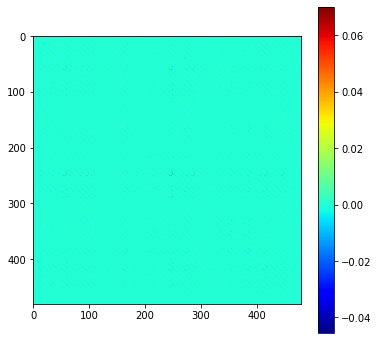

In [54]:
plt.figure(figsize=(6,6))
plt.imshow(partialH[0:480,0:480],cmap="jet")
plt.colorbar()

In [55]:
partialH = np.zeros((10,10));
for i in tqdm(range(10)):
    v1 = tf.Variable(np.zeros((784,128),dtype=np.float32));
    v2 = tf.Variable(np.zeros((128,),dtype=np.float32));
    v3 = tf.Variable(np.zeros((128,10),dtype=np.float32));
    v4 = np.zeros((10,));
    v4[i] = 1.0;
    v4 = tf.Variable(v4,dtype=np.float32);
    v = [v1,v2,v3,v4]
    #print(H.action(v)[2].numpy().reshape((128*10,)))
    partialH[:,i] = H.action(v)[3].numpy().reshape(10,);

  0%|          | 0/10 [00:00<?, ?it/s]

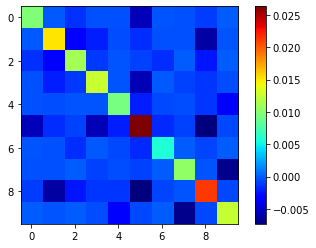

In [56]:
plt.imshow(partialH,cmap="jet")
plt.colorbar()

In [64]:
fullH = np.zeros((128+128*10+10,128+128*10+10));
for i in tqdm(range(128)):
    v1 = tf.Variable(np.zeros((784,128),dtype=np.float32));
    v2 = np.zeros((128,),dtype=np.float32);
    v2[i]=1;
    v2 = tf.Variable(v2,dtype=np.float32)
    v3 = tf.Variable(np.zeros((128,10),dtype=np.float32));
    v4 = tf.Variable(np.zeros((10,),dtype=np.float32));
    v = [v1,v2,v3,v4]
    fullH[0:128,i] = H.action(v)[1].numpy().reshape(128,);
    fullH[128:128+128*10,i] = H.action(v)[2].numpy().reshape(1280,);
    fullH[128+128*10:,i] = H.action(v)[3].numpy().reshape(10,);
for i in tqdm(range(128*10)):
    v1 = tf.Variable(np.zeros((784,128),dtype=np.float32));
    v2 = tf.Variable(np.zeros((128,),dtype=np.float32));
    v3 = np.zeros((128*10),dtype=np.float32);
    v3[i] = 1.0;
    v3 = tf.Variable(v3.reshape([128,10]));
    v4 = tf.Variable(np.zeros((10,),dtype=np.float32));
    v = [v1,v2,v3,v4]
    fullH[0:128,128+i] = H.action(v)[1].numpy().reshape(128,);
    fullH[128:128+128*10,128+i] = H.action(v)[2].numpy().reshape(1280,);
    fullH[128+128*10:,128+i] = H.action(v)[3].numpy().reshape(10,);
for i in tqdm(range(10)):
    v1 = tf.Variable(np.zeros((784,128),dtype=np.float32));
    v2 = tf.Variable(np.zeros((128,),dtype=np.float32));
    v3 = tf.Variable(np.zeros((128,10),dtype=np.float32));
    v4 = np.zeros((10,));
    v4[i] = 1.0;
    v4 = tf.Variable(v4,dtype=np.float32);
    v = [v1,v2,v3,v4]
    fullH[0:128,128*11+i] = H.action(v)[1].numpy().reshape(128,);
    fullH[128:128+128*10,128*11+i] = H.action(v)[2].numpy().reshape(1280,);
    fullH[128+128*10:,128*11+i] = H.action(v)[3].numpy().reshape(10,);

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/1280 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

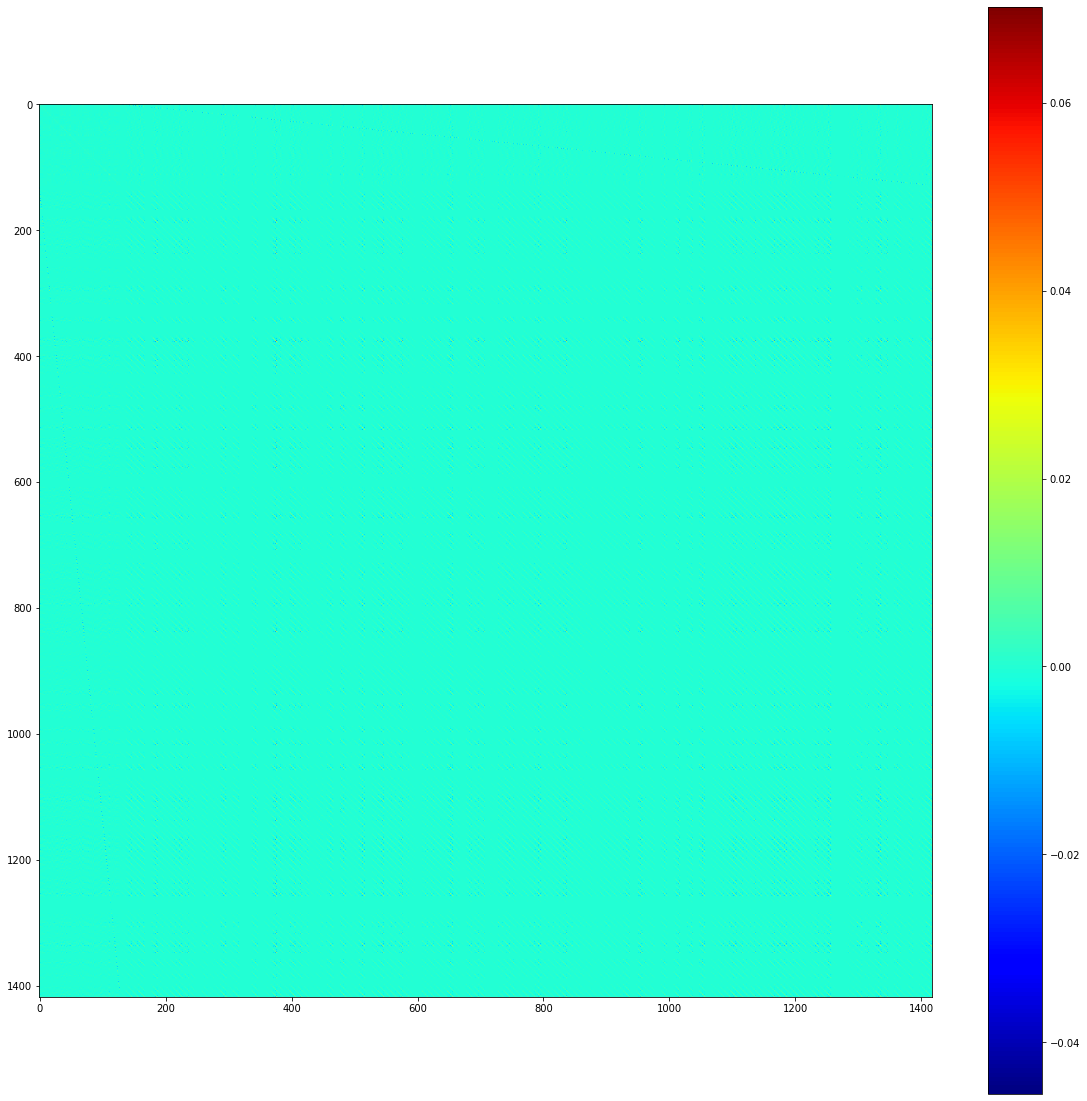

In [68]:
N=128+1280+10
plt.figure(figsize=(20,20))
plt.imshow(fullH[0:N,0:N],cmap="jet")
plt.colorbar()